In [46]:
import cv2   
import numpy as np   
import matplotlib.pyplot as plt
import imutils
from scipy.spatial import ConvexHull

In [124]:
coordinates = []
def click_event(event, x, y, flags, params):
  
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
  
        # displaying the coordinates
        # on the image window
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         cv2.putText(img, str(x) + ',' +
#                     str(y), (x,y), font,
#                     1, (255, 0, 0), 2)
        cv2.imshow('image', img)
        coordinates.append([x,y])
  
    # checking for right mouse clicks     
    if event==cv2.EVENT_RBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
  
        # displaying the coordinates
        # on the image window
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         b = img[y, x, 0]
#         g = img[y, x, 1]
#         r = img[y, x, 2]
#         cv2.putText(img, str(b) + ',' +
#                     str(g) + ',' + str(r),
#                     (x,y), font, 1,
#                     (255, 255, 0), 2)
        cv2.imshow('image', img)
        coordinates.append([x,y])

In [125]:
fileName = 'vis_Bakul_001_00060.png'
imgDirPath = 'F:\\IIIT-H Work\\win_det_heatmaps\\testPanaroma\\infer_result\\'

# fileName = 'vis_Bakul_002_000970.png'
# imgDirPath = 'F:\\IIIT-H Work\\win_det_heatmaps\\rrcServerData\\templateMatching\\images\\resnet\\'

imgPath = imgDirPath + fileName
# Reading the main image   
img = cv2.imread(imgPath,1)
img_show = np.copy(img)
img_copy = np.copy(img)
img_rgb = np.copy(img)

210   3
211   131
376   128
370   2
619   5
610   130
774   131
782   2


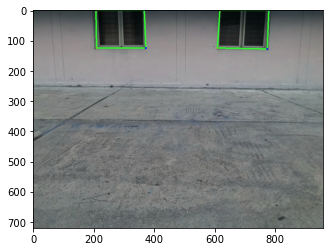

In [126]:
plt.figure()
plt.imshow(img_rgb)
cv2.imshow('image',img_rgb)

# setting mouse hadler for the image
# and calling the click_event() function
cv2.setMouseCallback('image', click_event)

# wait for a key to be pressed to exit
cv2.waitKey(0)

# close the window
cv2.destroyAllWindows()

In [128]:
#print(coordinates)
#coordinates = coordinates[0:2]
#coordinates = [[340, 5], [340, 127], [498, 125], [499, 1], [731, 2], [725, 129], [885, 128], [892, 2]]

#coordinates = [[339, 3], [338, 126], [497, 123], [498, 4], [731, 4], [725, 130], [882, 128], [890, 2], [2, 390], [2, 497], [132, 500], [129, 394], [335, 396], [341, 508], [494, 505], [495, 397]]

print(coordinates)
print("\n")

coords = np.array(coordinates)
coords = np.reshape(coords,(coords.shape[0]//4 , 4, coords.shape[1]))
print(coords)
print(coords[0])


[[210, 3], [211, 131], [376, 128], [370, 2], [619, 5], [610, 130], [774, 131], [782, 2]]


[[[210   3]
  [211 131]
  [376 128]
  [370   2]]

 [[619   5]
  [610 130]
  [774 131]
  [782   2]]]
[[210   3]
 [211 131]
 [376 128]
 [370   2]]


In [129]:
# Loop through list to find range of x and y

def calculateRange(coordinates, padding, imageShape):
    minX = maxX = coordinates[0][0]
    minY = maxY = coordinates[0][1]
    startX = startY = endX = endY = 0
    h,w,c = imageShape
    for i in range(len(coordinates)):
        if minX > coordinates[i][0]:
            minX = coordinates[i][0]
        if maxX < coordinates[i][0]:
            maxX = coordinates[i][0]

        if minY > coordinates[i][1]:
            minY = coordinates[i][1]
        if maxY < coordinates[i][1]:
            maxY = coordinates[i][1]
    
    if (minX - padding < 0):
        startX = 0
    else:
        startX = minX - padding
    if (minY - padding < 0):
        startY = 0
    else:
        startY = minY - padding
    if (maxX + padding >= w):
        endX = w - 1
    else:
        endX = maxX + padding
    if (maxY + padding >= h):
        endY = h - 1
    else:
        endY = maxY + padding
    return startX, endX, startY, endY

In [130]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [131]:
def mapCoordsToOriginalFrame(coords, searchImgCoords):
    mappedCoords = []
    startX, endX, startY, endY = searchImgCoords
    
    for i in range(len(coords)):
        mappedCoords.append((coords[i][0], coords[i][1] + startY, coords[i][2], coords[i][3] + startY))
    return mappedCoords

def template_plot(template,searchImg,fileName,figname):
    plt.figure(num=figname, figsize=(20,10))
    plt.subplot(1, 2, 2)
    plt.imshow(template)
    plt.title('template_' + str(fileName))     
    plt.subplot(1, 2, 1)
    plt.imshow(searchImg)
    plt.title('templateMatched_' + str(fileName)) 
    plt.show()


In [132]:
def matchTemplate(tW_all, tH_all, rects_all, ind, coordinates, img_rgb, fileName, padding=10):    
    
    startX, endX, startY, endY = calculateRange(coordinates, padding, img_rgb.shape)
    plt.imshow(img_rgb)
    #print(startX, endX, startY, endY)
    #print(img_rgb.shape)
    
    template = img_rgb[startY:endY, startX:endX, :]
    searchImg = img_rgb[startY:endY, : ,:]
    searchImg_copy = np.copy(searchImg)

    template_plot(template,searchImg,fileName,fileName)
    
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)   
    searchImg_gray = cv2.cvtColor(searchImg, cv2.COLOR_BGR2GRAY)
    
    rects = []
    for i in [-2.5, 0, 2.5]:
        # Apply rotation and shear to template
        rotatedTemplate = imutils.rotate(template, i)
        plt.imshow(rotatedTemplate)
        plt.title('rotatedTemplate_' + str(fileName)) 

        template_gray = cv2.cvtColor(rotatedTemplate, cv2.COLOR_BGR2GRAY)   

        # Store width in variable w and height in variable h of template  
        tW, tH = template_gray.shape[::-1]   
        # Now we perform match operations.   
        res = cv2.matchTemplate(searchImg_gray,template_gray,cv2.TM_CCOEFF_NORMED)   
        # Declare a threshold   
        threshold = 0.550
        # Store the coordinates of matched region in a numpy array   
        loc = np.where( res >= threshold)
        print(loc)
        # Draw a rectangle around the matched region.   
        for pt in zip(*loc[::-1]): 
            #print('x: ' + str(pt[0]) + ' y: ' + str(pt[1]))
            cv2.rectangle(searchImg, pt, (pt[0] + tW, pt[1] + tH), (255,0,0), 1)   
            rects.append((pt[0], pt[1], pt[0] + tW, pt[1] + tH))

    # Now display the final matched template image
    plt.figure(num=ind)
    plt.imshow(searchImg)  
    plt.title('Result on search Image')
    plt.show()

    #cv2.imwrite('Template_' +  '0.6_threshold_' + fileName, template)
    #cv2.imwrite('TemplateMatched_'  + '0.6_threshold_' + fileName, searchImg)

    #print(np.array(rects).shape)    
    #print(rects)
    #for i in range(len(rects)):
    #    print(rects[i][0])
        
    searchImgCoords = startX, endX, startY, endY
    print("rects: " + str(rects))
    print("\n")
    mappedCoords = mapCoordsToOriginalFrame(rects, searchImgCoords)
    print("mappedCoords: " + str(mappedCoords))

    for pt in (mappedCoords): 
        #print(str(pt[0]) + " "  + str(pt[1]))
        #print(str(pt[2]) + " "  + str(pt[3]))
        cv2.rectangle(img_show, (pt[0],pt[1]),  (pt[2], pt[3]), (255,0,0), 1)   
    
    print(mappedCoords[0][0])
    # Now display the final matched template image   
    plt.figure(num = 'mapped' + fileName, figsize=(20,10))
    plt.imshow(img_show)  
    plt.title('Final Result')

    tW_new = tW * np.ones(len(mappedCoords),dtype=int)
    tH_new = tH * np.ones(len(mappedCoords),dtype=int)
    
    rects_all = rects_all + mappedCoords
    tW_all.append(tW_new)
    tH_all.append(tH_new)
    
    return tW_all, tH_all, rects_all


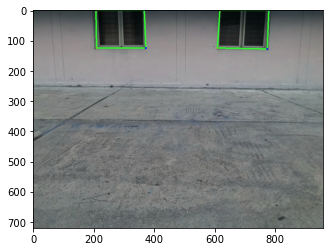

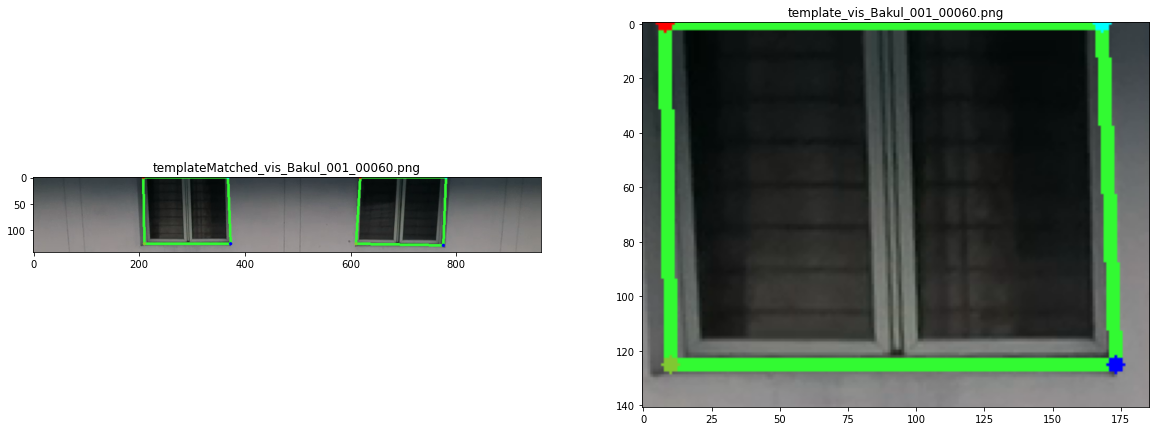

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64), array([190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 591, 592, 593,
       594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606,
       607, 608, 609, 610, 611, 612, 613, 614], dtype=int64))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 597, 598, 599, 600, 601, 602, 603, 604,
       605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617,
       618, 619, 620, 621, 622, 623], dtype=i

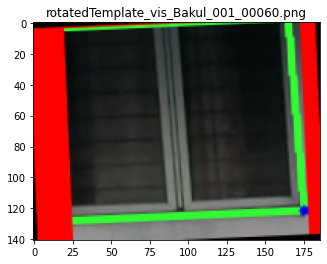

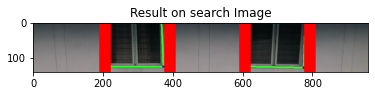

rects: [(190, 0, 376, 141), (191, 0, 377, 141), (192, 0, 378, 141), (193, 0, 379, 141), (194, 0, 380, 141), (195, 0, 381, 141), (196, 0, 382, 141), (197, 0, 383, 141), (198, 0, 384, 141), (199, 0, 385, 141), (200, 0, 386, 141), (201, 0, 387, 141), (202, 0, 388, 141), (203, 0, 389, 141), (204, 0, 390, 141), (205, 0, 391, 141), (206, 0, 392, 141), (207, 0, 393, 141), (208, 0, 394, 141), (209, 0, 395, 141), (210, 0, 396, 141), (211, 0, 397, 141), (212, 0, 398, 141), (591, 0, 777, 141), (592, 0, 778, 141), (593, 0, 779, 141), (594, 0, 780, 141), (595, 0, 781, 141), (596, 0, 782, 141), (597, 0, 783, 141), (598, 0, 784, 141), (599, 0, 785, 141), (600, 0, 786, 141), (601, 0, 787, 141), (602, 0, 788, 141), (603, 0, 789, 141), (604, 0, 790, 141), (605, 0, 791, 141), (606, 0, 792, 141), (607, 0, 793, 141), (608, 0, 794, 141), (609, 0, 795, 141), (610, 0, 796, 141), (611, 0, 797, 141), (612, 0, 798, 141), (613, 0, 799, 141), (614, 0, 800, 141), (192, 0, 378, 141), (193, 0, 379, 141), (194, 0, 380

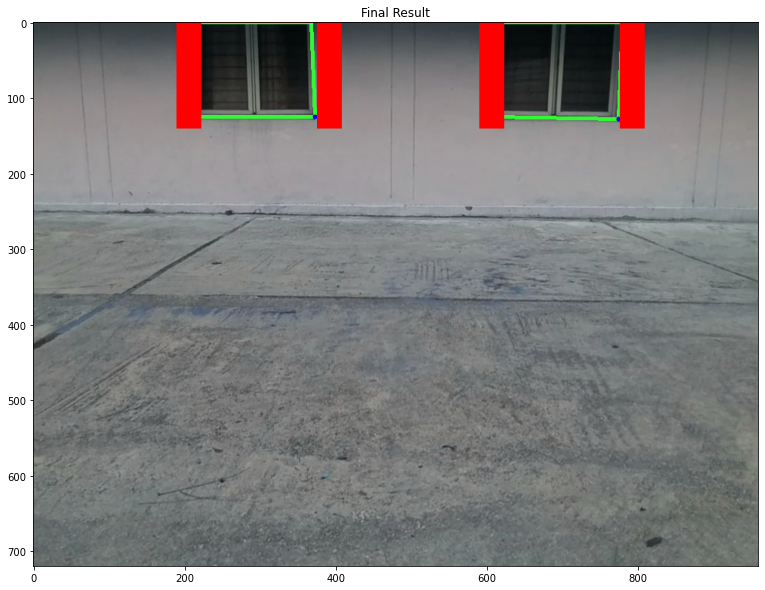

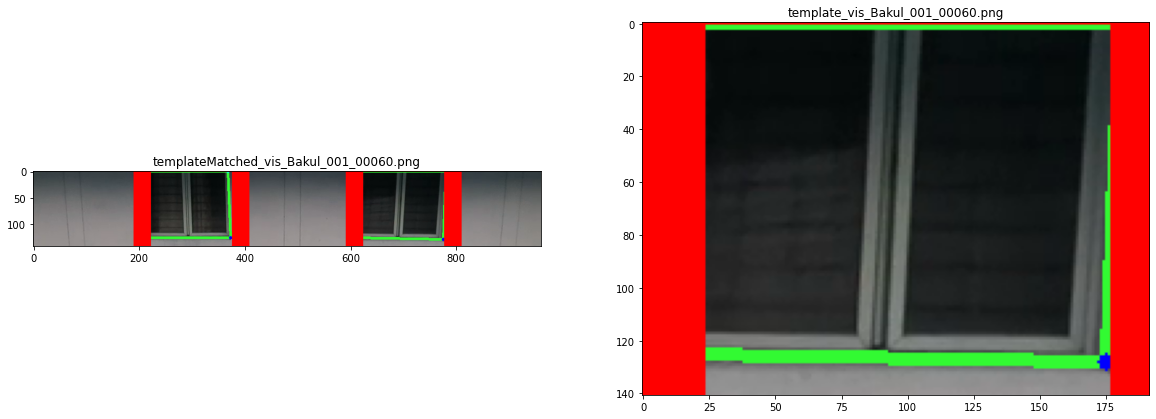

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 587, 588,
       589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601,
       602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614,
       615, 616, 617], dtype=int64))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 5

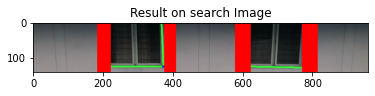

rects: [(189, 0, 381, 141), (190, 0, 382, 141), (191, 0, 383, 141), (192, 0, 384, 141), (193, 0, 385, 141), (194, 0, 386, 141), (195, 0, 387, 141), (196, 0, 388, 141), (197, 0, 389, 141), (198, 0, 390, 141), (199, 0, 391, 141), (200, 0, 392, 141), (201, 0, 393, 141), (202, 0, 394, 141), (203, 0, 395, 141), (204, 0, 396, 141), (205, 0, 397, 141), (206, 0, 398, 141), (207, 0, 399, 141), (208, 0, 400, 141), (209, 0, 401, 141), (210, 0, 402, 141), (211, 0, 403, 141), (212, 0, 404, 141), (587, 0, 779, 141), (588, 0, 780, 141), (589, 0, 781, 141), (590, 0, 782, 141), (591, 0, 783, 141), (592, 0, 784, 141), (593, 0, 785, 141), (594, 0, 786, 141), (595, 0, 787, 141), (596, 0, 788, 141), (597, 0, 789, 141), (598, 0, 790, 141), (599, 0, 791, 141), (600, 0, 792, 141), (601, 0, 793, 141), (602, 0, 794, 141), (603, 0, 795, 141), (604, 0, 796, 141), (605, 0, 797, 141), (606, 0, 798, 141), (607, 0, 799, 141), (608, 0, 800, 141), (609, 0, 801, 141), (610, 0, 802, 141), (611, 0, 803, 141), (612, 0, 804

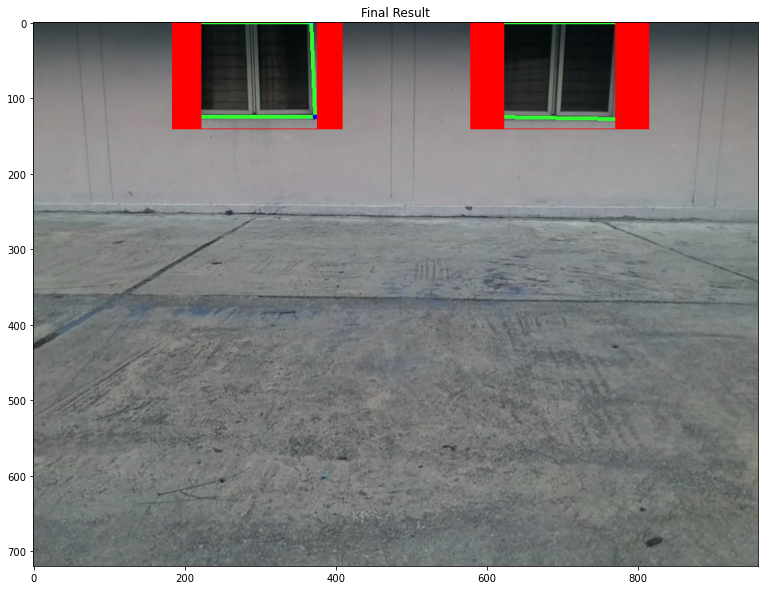

In [133]:
rects_all = []
tW_all = []
tH_all = []

#tW_all, tH_all, rects_all = matchTemplate(tW_all, tH_all, rects_all, 1, coords[0], img_rgb, fileName, padding=10)
for ind in range(coords.shape[0]):
    tW_all, tH_all, rects_all = matchTemplate(tW_all, tH_all, rects_all, ind, coords[ind], img_rgb, fileName, padding=10)

[(190, 0, 376, 141), (191, 0, 377, 141), (192, 0, 378, 141), (193, 0, 379, 141), (194, 0, 380, 141), (195, 0, 381, 141), (196, 0, 382, 141), (197, 0, 383, 141), (198, 0, 384, 141), (199, 0, 385, 141), (200, 0, 386, 141), (201, 0, 387, 141), (202, 0, 388, 141), (203, 0, 389, 141), (204, 0, 390, 141), (205, 0, 391, 141), (206, 0, 392, 141), (207, 0, 393, 141), (208, 0, 394, 141), (209, 0, 395, 141), (210, 0, 396, 141), (211, 0, 397, 141), (212, 0, 398, 141), (591, 0, 777, 141), (592, 0, 778, 141), (593, 0, 779, 141), (594, 0, 780, 141), (595, 0, 781, 141), (596, 0, 782, 141), (597, 0, 783, 141), (598, 0, 784, 141), (599, 0, 785, 141), (600, 0, 786, 141), (601, 0, 787, 141), (602, 0, 788, 141), (603, 0, 789, 141), (604, 0, 790, 141), (605, 0, 791, 141), (606, 0, 792, 141), (607, 0, 793, 141), (608, 0, 794, 141), (609, 0, 795, 141), (610, 0, 796, 141), (611, 0, 797, 141), (612, 0, 798, 141), (613, 0, 799, 141), (614, 0, 800, 141), (192, 0, 378, 141), (193, 0, 379, 141), (194, 0, 380, 141),

Text(0.5, 1.0, 'After NMS')

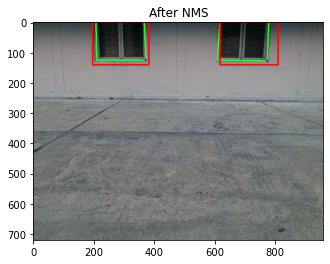

In [134]:
#---------NMS after TM of all model-detected windows----------

#boxes is an array of bounding boxes each with 2 co-ordinates - (x1, y1, x2, y2)
#lower left is (x1,y1), upper right is (x2,y2)

overlapThresh = 0.25
boxes = rects_all
for i in range(len(boxes)):
    boxes[i] = list(boxes[i])

boxes = np.array(rects_all)
xCoords = boxes[:,0]
yCoords = boxes[:,1]
xCoords2 = boxes[:,2]
yCoords2 = boxes[:,3]

boxes_tuples = []
#loop over the starting (x, y)-coordinates again
for (x, y, x2, y2) in zip(xCoords, yCoords, xCoords2, yCoords2):
    # update our list of rectangles
    boxes_tuples.append((x, y, x2, y2))

print(boxes_tuples)

# apply non-maxima suppression to the rectangles
pick = non_max_suppression_fast(np.array(boxes_tuples),overlapThresh)
print("[INFO] {} matched locations *after* NMS".format(len(pick)))
# loop over the final bounding boxes
print(pick)
for (sX, sY, eX, eY) in pick:
    # draw the bounding box on the image
    cv2.rectangle(img_copy, (sX, sY), (eX, eY),
        (255, 0, 0), 3)
plt.figure(num = 'nms')
plt.imshow(img_copy)
plt.title("After NMS")


In [135]:
print('Number of windows detected by the model and post processing: ', len(pick))

Number of windows detected by the model and post processing:  2


In [136]:
############### Calculating storey #####################
def calculateStoreys(coords):
    yTop = coords[:,1]
    yBottom = coords[:,3]
    yAvg = (yTop + yBottom)/2
#     print(yTop)
#     print(yBottom)
#     print(yAvg)
    storeyCount = 1 if len(coords) > 0 else 0
    index = 0
    for i in range(len(coords)):
        if ((yAvg[index] > yTop[i]) and (yAvg[index] < yBottom[i])):
            continue
        else:
            storeyCount+=1
            index = i
    print('Number of storeys after running post processing module: ', storeyCount)
    return storeyCount

In [137]:
calculateStoreys(pick)

Number of storeys after running post processing module  1


1